In [1]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# df = pd.read_parquet(r'/home/pk21271/prep_data/mlp_binary_raw/df.parquet')
# # Data prep
# df = df.dropna()
# df = df[df['weight_nominal'] >= 0]
# df = df[~df.region.isin([1, 2, 3, 4, 5])]

# # Do weights
# signal_weights_sum = df[df['target'] == 1]['weight_nominal'].sum()
# bkg_weights_sum = df[df['target'] == 0]['weight_nominal'].sum()

# sig_factor = len(df[df['target'] == 1]) / signal_weights_sum
# bkg_factor = len([df['target'] == 0]) / bkg_weights_sum

# df['weight_training'] = df['weight_nominal']

# df.loc[df["target"] == 1, "weight_training"] *= sig_factor
# df.loc[df["target"] == 0, "weight_training"] *= bkg_factor

In [2]:
# # Data loaders

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
#        'InputMet_pt', 'MHT_pt', 'MinChi',
#        'MinOmegaHat', 'MinOmegaTilde', 'ldphi_bjet',
#        'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
#        'sdphi_jet']

# # Standardize the features
# scaler = StandardScaler()
# df[features] = scaler.fit_transform(df[features])

# # Convert df to PyTorch tensors
# X = torch.tensor(df[features].values, dtype=torch.float32)
# y = torch.tensor(df['target'].values, dtype=torch.float32)  # For BCE loss, use float labels
# wn = torch.tensor(df['weight_nominal'].values, dtype=torch.float32)
# wt = torch.tensor(df['weight_training'].values, dtype=torch.float32)

# # Split df into training+validation and test sets (80/20)
# X_train, X_val, y_train, y_val, wn_train, wn_val, wt_train, wt_val = train_test_split(X, y, wn, wt, test_size=0.2, random_state=42)

# batch_size = 1024

# # Create DataLoaders for each set
# train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wt_train), batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wt_val), batch_size=batch_size, shuffle=False)


In [3]:
# torch.save(X, '/home/pk21271/prep_data/mlp_binary_raw/X.pt')
# torch.save(y, '/home/pk21271/prep_data/mlp_binary_raw/y.pt')
# torch.save(wn, '/home/pk21271/prep_data/mlp_binary_raw/wn.pt')
# torch.save(wt, '/home/pk21271/prep_data/mlp_binary_raw/wt.pt')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = torch.load('/home/pk21271/prep_data/mlp_binary_raw/X.pt')
y = torch.load('/home/pk21271/prep_data/mlp_binary_raw/y.pt')
wn = torch.load('/home/pk21271/prep_data/mlp_binary_raw/wn.pt')
wt = torch.load('/home/pk21271/prep_data/mlp_binary_raw/wt.pt')


# Split df into training+validation and test sets (80/20)
X_train, X_val, y_train, y_val, wn_train, wn_val, wt_train, wt_val = train_test_split(X, y, wn, wt, test_size=0.2, random_state=42)

batch_size = 1024

# # Create DataLoaders for each set
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wt_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wt_val), batch_size=batch_size, shuffle=False)

/tmp/ipykernel_2783401/3115208613.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('/home/pk21271/prep_data/mlp_binary_raw/X.pt')
/tmp/ipykernel_2783401/3

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

class MLP(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001):
        super().__init__()
        self.save_hyperparameters()  # Saves hyperparameters automatically

        # Define a 3-layer MLP
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),

            nn.Linear(hidden_dim, 1)  # Output layer for binary classification
        )

        # Loss function (Binary Cross-Entropy with Logits)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.lr = lr  # Learning rate

    def forward(self, x):
        return self.model(x)

    # def training_step(self, batch, batch_idx):
    #     x, y, wn, wt = batch
    #     # Ensure wt is on the same device as x and logits
    #     wt = wt.to(x.device)
    #     logits = self(x)
    #     loss = self.loss_fn(logits, y.unsqueeze(1))
    #     weighted_loss = (loss * wt).mean()  # This should be fast if wt is on the GPU
    #     self.log("train_loss", weighted_loss, prog_bar=True, on_epoch=True, on_step=False)
    #     return weighted_loss

    # def validation_step(self, batch, batch_idx):
    #     x, y, wn, wt = batch
    #     logits = self(x)
    #     loss = self.loss_fn(logits, y.unsqueeze(1))
    #     weighted_loss = (loss * wt).mean()
    #     self.log("val_loss", weighted_loss, prog_bar=True, on_epoch=True, on_step=False)
    #     return weighted_loss
    
    def training_step(self, batch, batch_idx):
        x, y, wn, wt = batch
        # Ensure wt is on the same device as x and logits
        wt = wt.to(x.device)
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1))
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, wn, wt = batch
        logits = self(x)
        loss = self.loss_fn(logits, y.unsqueeze(1))
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer = optimizer,
            mode = 'min', 
            factor = 0.2, 
            patience = 4, #Was 10
            threshold = 0., 
            threshold_mode = 'rel', 
            cooldown = 0, 
            min_lr = 1e-8,
            )
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def predict_step(self, batch, batch_idx):
        x, y, wn, wt = batch  # Ensure correct unpacking
        logits = self.forward(x)
        return logits  # Return probabilities for binary classification


In [ ]:
model  = MLP(input_dim=X_train.size(1), hidden_dim=64, lr=0.01)

# Train the model

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

max_epochs = 5

trainer = pl.Trainer(max_epochs=max_epochs,
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    devices = [0])

trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Accelerator : gpu


/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/5
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/5
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/5
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/5
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/5
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting wi

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=8` in the `DataLoader` to improve performance.
/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=8` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:439: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
Exception ignored in: /software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fad8dab9070>><bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fad8dab9070>>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
  File "/software/pk21271/mini

KeyboardInterrupt: : 



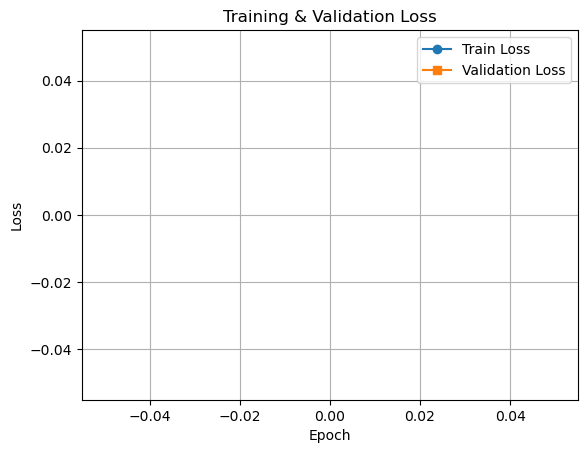

NameError: name 'self' is not defined

In [ ]:
plt.plot(model.train_loss_history, label="Train Loss", marker="o")
plt.plot(model.val_loss_history, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

print(self.trainer.logged_metrics )

In [ ]:
single_gpu_trainer = pl.Trainer(accelerator="gpu", devices=1)
preds_raw = single_gpu_trainer.predict(model=model, dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/software/pk21271/miniconda3/envs/env_new/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import numpy as np
preds = torch.cat(preds_raw, dim=0)
probs = torch.sigmoid(preds).detach().cpu().numpy().flatten()

wn = np.array((wn_val * 200000).flatten()) # Multiply by 200,000 to get the original weights
labels = np.array(y_val.flatten())

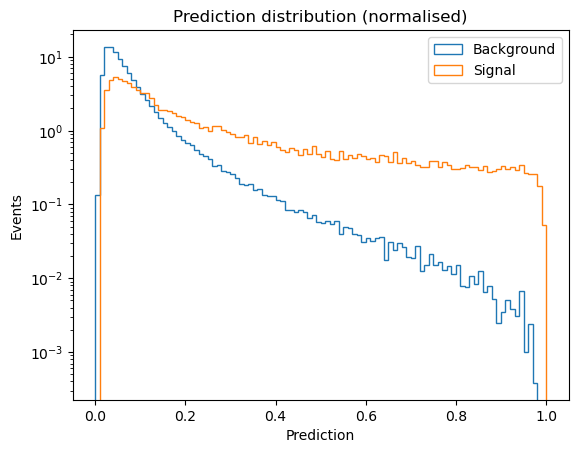

In [ ]:
plt.hist(probs[labels == 0], bins=100, range=(0, 1), weights=wn[labels == 0], histtype='step', label='Background', density = True)
plt.hist(probs[labels == 1], bins=100, range=(0, 1), weights=wn[labels == 1], histtype='step', label='Signal', density = True)
plt.legend()  
plt.xlabel('Prediction')
plt.ylabel('Events')
plt.title('Prediction distribution (normalised)')   
plt.yscale('log')
plt.show()

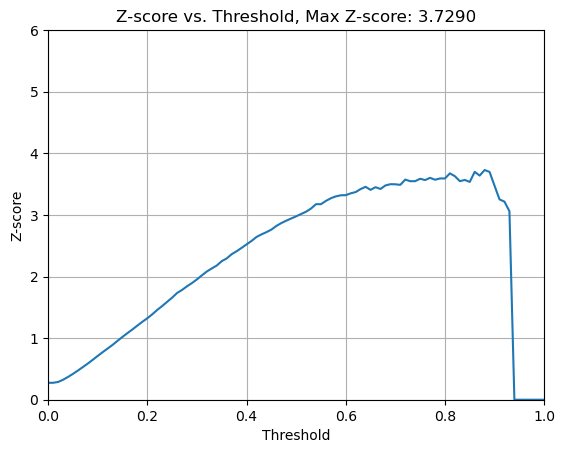

In [ ]:
# Assume w_test is the array of weights for each sample in the test set
wn_val_array = np.array(wn_val*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)
z_scores = []

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn_val_array[(probs > threshold) & (labels == 1)])  # Weighted Signal
    B = np.sum(wn_val_array[(probs > threshold) & (labels == 0)])  # Weighted Background
    sig_B = B * 0.05 # 5% error
    
    if S and B > 3:
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)
    else:
        Z = 0

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score vs. Threshold, Max Z-score: {max(z_scores[:95]):.4f}")
plt.grid()
plt.ylim(0,6)
plt.xlim(0,1)
plt.show()

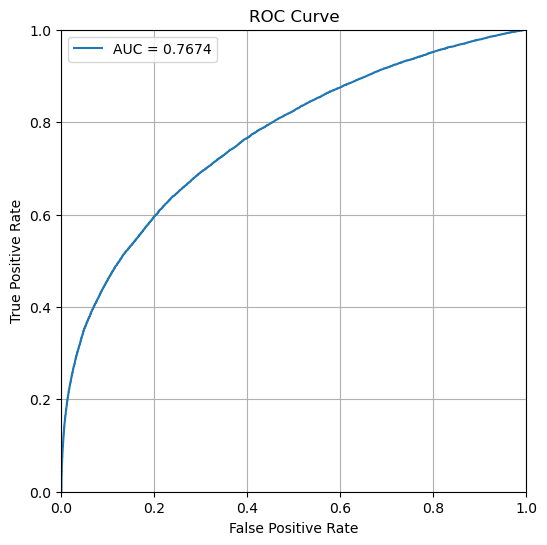

In [ ]:
# Plot roc curve

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(labels, probs, sample_weight=wn_val_array)
auc = roc_auc_score(labels, probs, sample_weight=wn_val_array)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()